# Real data asymmetry

We calculate different asymmetry values for the HST, HSC, and SDSS data (and later, UNIONS) using our 4 different methods. The idea is that each galaxy should have the same asymmetry in different imaging, regardless of the instrument Fingers crossed...

Try two approaches:

1. Use a detection map based on HSC to mask other sources. Use the same segmap in all three cases.
2. Create a different detection map for each image

**Convert all images to the same pixel scale of 0.1 arcsec / px**

#### Imports

In [1]:
%reload_ext autoreload
%autoreload 2

import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
from astropy.io import fits
from photutils.segmentation import detect_sources, deblend_sources
from astropy.convolution import Gaussian2DKernel, convolve, Tophat2DKernel, Box2DKernel
from astropy.stats import sigma_clipped_stats, sigma_clip
from reproject import reproject_interp, reproject_adaptive, reproject_exact
from astropy.visualization import AsymmetricPercentileInterval, AsinhStretch
from astropy.wcs import WCS
from photutils.centroids import centroid_com
from scipy import optimize as opt
import photutils as phot
from skimage import measure
from asymmetry import get_asymmetry, fourier_deconvolve, _asymmetry_func, _sky_properties
from skimage import transform as T
from astropy.convolution import interpolate_replace_nans
from scipy import fft
from matplotlib import patches

norm = AsymmetricPercentileInterval(10, 99.6)
stretch = AsinhStretch(0.6)

example = True
exname = 'J085357+031034'
desired_pxscale = 0.2

In [2]:
plt.rcParams['image.interpolation'] = 'None'

Load in the data frame:

In [3]:
df = pd.read_csv('data/catalogs/data.csv')
df = df[df.hsc]
df.head(2)

name        ra       dec    lmass50         z dataset   cfis  \
0  J000318+004844  0.825888  0.812301  10.820000  0.138889    spog  False   
1  J001145-005431  2.938389 -0.908503  10.221996  0.047883    spog  False   

    hsc  
0  True  
1  True

Load in an example galaxy:

In [4]:
if example:
    ex_sdss_f = fits.open(f'data/sdss/i/{exname}.fits')
    ex_hst_f = fits.open(f'data/hst/F814W/{exname}.fits')
    ex_hsc_f = fits.open(f'data/hsc/{exname}.fits')
    ex_inf = df[df['name'] == exname].iloc[0]
    ex_files = [ex_sdss_f, ex_hst_f, ex_hsc_f]

Rescale everything to the same size; change the WCS

In [5]:
def rescale(file, ra, dec, sdss=False):

    f = file.copy()
    
    # Create a new WCS
    old_size = f[0].data.shape[0]
    size = 80/desired_pxscale
    wcs_new = WCS(naxis=2)
    wcs_new.wcs.crval = [ra, dec]
    wcs_new.wcs.crpix = np.array([size/2, size/2])
    wcs_new.wcs.pc = np.array([[0, desired_pxscale/3600], [desired_pxscale/3600, 0]])
    wcs_new.wcs.ctype = ["RA---TAN", "DEC--TAN"]
    size = int(size)
    
    # Old WCS
    wcs = WCS(f['IMAGE'].header)
    try:
        pxscale_old = np.sqrt(np.abs(np.linalg.det(wcs.wcs.pc))) * 3600
    except:
        pxscale_old = np.sqrt(np.abs(np.linalg.det(wcs.wcs.cd))) * 3600
    factor = desired_pxscale / pxscale_old
    
    # Rescale all extensions
    extnames = ['IMAGE', 'ERR']
    for extname in extnames:
        
        
        if factor < 1:
            img = f[extname].data
            N = img.shape[0]

            # Rescale in the fourier domain. Normally, you would pad the frequency spectrum by 0s in the
            # New high-frequency pixels. We want to preserve noise (which exists on all scales), so add
            # Some noise in the high-frequency areas.
            # This gets read of artifacts on the noise level that we have otherwise when we upscale by interpolation.
            img_fft = fft.fft2(img)
            img_fft = fft.ifftshift(img_fft)
            
            bgsd = sigma_clipped_stats(np.abs(img_fft))[2]
            
 
            
            newsize = (size,size)#(int(img.shape[0]*(1/factor)), int(img.shape[1]*(1/factor)))
            padsize = (newsize[0]-img.shape[0], newsize[1]-img.shape[1])
            img_zeros = np.pad(img_fft, (((padsize[0]+1)//2, padsize[0]//2), ((padsize[1]+1)//2, padsize[1]//2)), constant_values=np.nan)
            img_const = np.pad(img_fft, (((padsize[0]+1)//2, padsize[0]//2), ((padsize[1]+1)//2, padsize[1]//2)), mode='edge')
            nans = np.isnan(img_zeros)
            img_zeros[nans] = img_const[nans] + np.random.normal(loc=0, scale=bgsd, size=np.sum(nans))
            img_fft = fft.fftshift(img_zeros)
            img_new = fft.ifft2(img_fft)
            

            # Orient SDSS the same way as other images
            if sdss: img_new = img_new[::-1].T
            f[extname].data = np.real(img_new)
            
            
        # For downscaling, no need to worry about this
        else:
            img = T.resize(f[extname].data, (size,size)) * factor**2
            if sdss: img = img[::-1].T
            f[extname].data = img
            
    mask = T.resize(f['MASK'].data, (size,size), order=0)
    # Orient SDSS the same way as other images
    if sdss: mask = mask[::-1].T
    f['MASK'].data = np.array(mask).astype(int)
    
    # Pad the original PSF to match original image size
    psf = f['PSF'].data
    padsize = (old_size - psf.shape[0], old_size - psf.shape[1])  # total amount of padding
    psf = np.pad(psf, (((padsize[0]+1)//2, padsize[0]//2), ((padsize[1]+1)//2, padsize[1]//2)), mode='constant')
    # Rescale the PSF to match the image size as well
    psf_resampled = T.resize(psf, (size,size), order=5)*factor**2
    # Orient SDSS the same way as other images
    # if sdss: psf_resampled = psf_resampled[::-1].T
    f['PSF'].data = psf_resampled / np.sum(psf_resampled)

    # Save the WCS to header
    wcs_header = wcs_new.to_header()
    for key, val in wcs_header.items():
        f['IMAGE'].header[key] = val

    return f

Rescale all the example files:

In [6]:
if example:
    ex_files = []
    for i, f in enumerate([ex_sdss_f, ex_hst_f, ex_hsc_f]):
        fnew = rescale(f, ex_inf.ra, ex_inf.dec, i==0)
        ex_files.append(fnew)
        

## Functions

We need to do these three steps:

1. Detect and mask extraneous sources using `detect_sources`
2. Calculate the Petrosian radius
3. Calculate asymmetry four ways
    1. CAS asymmetry as defined by statmorph
    2. Corrected CAS asymmetry (normalized by $F$ not $|F|$)
    3. Squared asymmetry
    4. Fourier squared asymmetry
    

### Utility plot

Given SDSS, HST, and HSC files, make a 3-subplot figure in the SDSS projection

In [7]:
def make_cutout(sdss_file, hst_file, hsc_file):
    
    sdss_wcs = WCS(sdss_file[0].header)
    
    # SDSS
    sdss_img = -2.5*np.log10(1e-9*np.abs(sdss_file[0].data) / desired_pxscale**2)
    
    # HST
    # hst_wcs = WCS(hst_file[0].header)
    hst_img = -2.5*np.log10(np.abs(hst_file[0].data) / desired_pxscale**2) + hst_file[0].header['zp']
    
    # HSC
    hsc_img = -2.5*np.log10(np.abs(hsc_file[0].data) / hsc_file[0].header['FLUXMAG0'] / desired_pxscale**2 )
    # hsc_wcs = WCS(hsc_file[0].header)

    # Define image size
    size = 40/desired_pxscale
    cent = 40/desired_pxscale
    
    # Make axes
    fig = plt.figure(figsize=(13,4))
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1)
    
    # Plot the three subplots
    imgs = [sdss_img, hst_img, hsc_img]
    # wcss = [sdss_wcs, hst_wcs, hsc_wcs]
    labels = ['SDSS', 'HST', 'HSC']
    axs = []
    for i, (img, label) in enumerate(zip(imgs, labels)):
        # Plot the galaxy
        ax = fig.add_subplot(1,3,i+1)#, projection=sdss_wcs)
        axs.append(ax)
        im = ax.imshow(img, cmap='gray_r', vmin=20, vmax=28)#, transform=ax.get_transform(wcs))
        ax.set_xlim(cent-size, cent+size)
        ax.set_ylim(cent-size, cent+size)
        ax.axis('off')
        
        # Add a label
        color = 'w' if np.sum(img[:50,:50]) > 1000 else 'k'
        ax.annotate(label, xy=(0.03, 0.97), xycoords='axes fraction', color=color, size=16, va='top')
    
    # Add a colorbar
    plt.subplots_adjust(wspace=0.01, hspace=0.01, left=0, bottom=0, top=1, right=0.94)
    cax = fig.add_axes([0.955, 0, 0.015, 1])
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label(r'SB [mag/arcsec$^2$]', size=14)
    
    return fig, axs

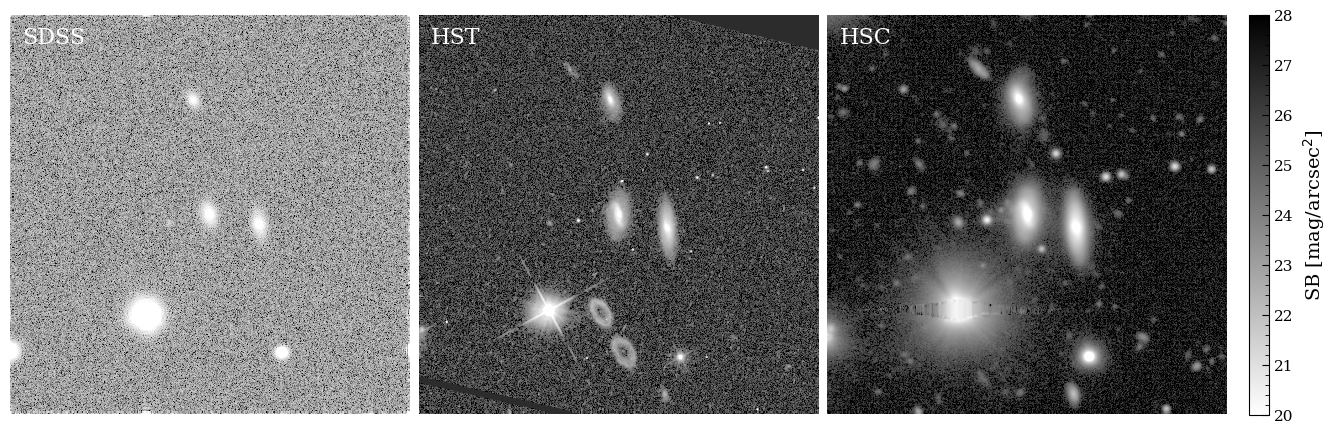

In [8]:
if example:
    make_cutout(*ex_files)

### Detect sources

#### Make segmap

* Convolve the data with a small Gaussian kernel to smooth the noise a bit
* Detect all sources in the image using a $5\sigma$ threshold to detect only bright objects
* Mask sources that are not the main object

In [9]:
def make_segmap(file, nthresh=7, npix=5):
    
    # Get the image and the mask
    img = file['IMAGE'].data
    mask = file['MASK'].data
    
    # Convolve the image
    img_conv = convolve(img, Gaussian2DKernel(3))
    # img = convolve(img, Gaussian2DKernel(2))
    
    # Find the background level
    bgmean, bgmed, bgstd = sigma_clipped_stats(img, sigma=3, mask=mask)

    # Cold mode: detect faint things far away from the galaxy
    segmap_cold = detect_sources(img_conv, threshold=1*bgstd, npixels=1)
    segmap_cold = deblend_sources(img, segmap_cold, npixels=300, contrast=0.05, progress_bar=False)
    # Medium mode: detect small faint clumps away from the galaxy that are still in scattered light
    segmap_med = detect_sources(img, threshold=7*bgstd, npixels=1)
    # Hot mode: detect small clumps in the galaxy
    segmap_hot = detect_sources(img_conv, threshold=10*bgstd, npixels=1, mask=mask)
    
    # For each, mask everything but the central source
    xc, yc = int(img.shape[1]/2), int(img.shape[0]/2)
    ms = []
    for segmap in [segmap_cold, segmap_med, segmap_hot]:
        source_label = segmap.data[yc, xc]
        m = np.zeros_like(img)
        m[(segmap.data > 0) & (segmap.data != source_label)] = 1
        ms.append(m)
    mask_segmap = ms[0].astype(bool) | ms[1].astype(bool) | ms[2].astype(bool)
    
    # Grow the mask by 2% of the image size
    size = int(0.02*img.shape[0])
    mask_segmap = convolve(mask_segmap, Box2DKernel(size))
    mask_segmap = mask_segmap > 0.1
    return mask_segmap

#### Project an HSC segmap onto another WCS

Adapt the HSC-based segmap to the HST/SDSS orientation, pixel scale etc using `reproject`.

In [10]:
# def convert_segmap(mask, hsc_f, file):
#     mask_proj, area = reproject_interp((mask, hsc_f[0].header), file[0].header, order=0)
#     mask_proj = (mask_proj.astype(bool) | ~area.astype(bool)).astype(int)
#     return mask_proj


Show an example:

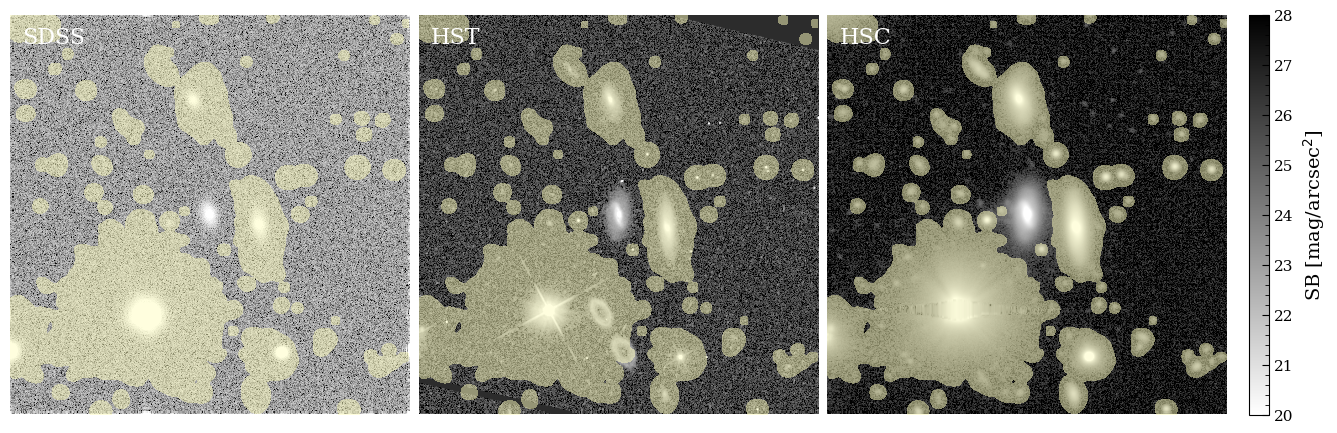

In [11]:
if example:
    fig, axs = make_cutout(*ex_files)
    
    ex_mask = make_segmap(ex_files[2])
    # ex_hst_mask = convert_segmap(ex_mask, ex_hsc_f, ex_hst_f)
    # ex_sdss_mask = convert_segmap(ex_mask, ex_hsc_f, ex_sdss_f)
    
    for ax, mask, f in zip(axs, 3*[ex_mask], ex_files):
        ax.contourf(mask, cmap='Spectral', levels=[0.9, 1.1], alpha=0.5)

### Petrosian radius

We use the statmorph method to calculate the Petrosian radius from the image, given the segmentation mask and the original image mask.

#### Petrosian function 

Helper function to evaluate the Petrosian ratio (from statmorph)

In [12]:
def _petrosian_function_circ(r, img_maskzeroed, center, annulus_width, eta=0.2):
    """
    Helper function to calculate the circular Petrosian radius.

    For a given radius ``r``, return the ratio of the mean flux
    over a circular annulus divided by the mean flux within the
    circle, minus "eta" (eq. 4 from Lotz et al. 2004). The root
    of this function is the Petrosian radius.
    """
    
    image = img_maskzeroed

    r_in = r - 0.5 * annulus_width
    r_out = r + 0.5 * annulus_width

    circ_annulus = phot.aperture.CircularAnnulus(center, r_in, r_out)
    circ_aperture = phot.aperture.CircularAperture(center, r)

    # Calculate fluxes
    circ_annulus_mean_flux = circ_annulus.do_photometry(image)[0][0] / circ_annulus.area
    circ_aperture_mean_flux = circ_aperture.do_photometry(image)[0][0] / circ_aperture.area
    ratio = circ_annulus_mean_flux / circ_aperture_mean_flux

    return ratio - eta

#### Optimal Rpet

This function finds the ratio between average and total flux for a range of R values, and optimizes it to find the radius where this ratio is equal to $\eta=0.2$.

In [13]:
def get_rpetro_circ(file, segmask):
    
    img = file['IMAGE'].data
    
    # Define a mask combining segmap and the original mask
    mask = (segmask.astype(bool) | file['MASK'].data.astype(bool))
    
    # Fill the masked regions with noise
    bgmean, bgmed, bgsd = sigma_clipped_stats(img, mask=mask)
    noise = np.random.normal(loc=bgmean, scale=bgsd, size=img.shape)
    img_maskzeroed = img.copy()
    # img_maskzeroed = convolve(img_maskzeroed, Gaussian2DKernel(3))
    img_maskzeroed[mask] = 0#noise[mask]
    
    # Find the centroid of the masked image
    x0, y0 = centroid_com(np.abs(img_maskzeroed)**2)
    center = np.array([x0, y0])
    
    # Find appropriate range for root finder
    npoints = 100    
    r_inner = img.shape[0]*0.01
    r_outer = img.shape[0]*0.4
    annulus_width = max(1, int(0.01*img.shape[0]+0.5))
    r_min, r_max = None, None
    for r in np.linspace(r_inner, r_outer, npoints):
        curval = _petrosian_function_circ(r, img_maskzeroed, center, annulus_width)
        if curval == 0: return r
        elif curval > 0:  # we have not reached rpetro yet
            r_min = r
        else: # beyond rpetro
            r_max = r
            break
            

    # Now run the root finder between those values
    rpetro_circ = opt.brentq(_petrosian_function_circ, r_min, r_max, args=(img_maskzeroed, center, annulus_width), xtol=1e-6)
    return rpetro_circ, center

Example:

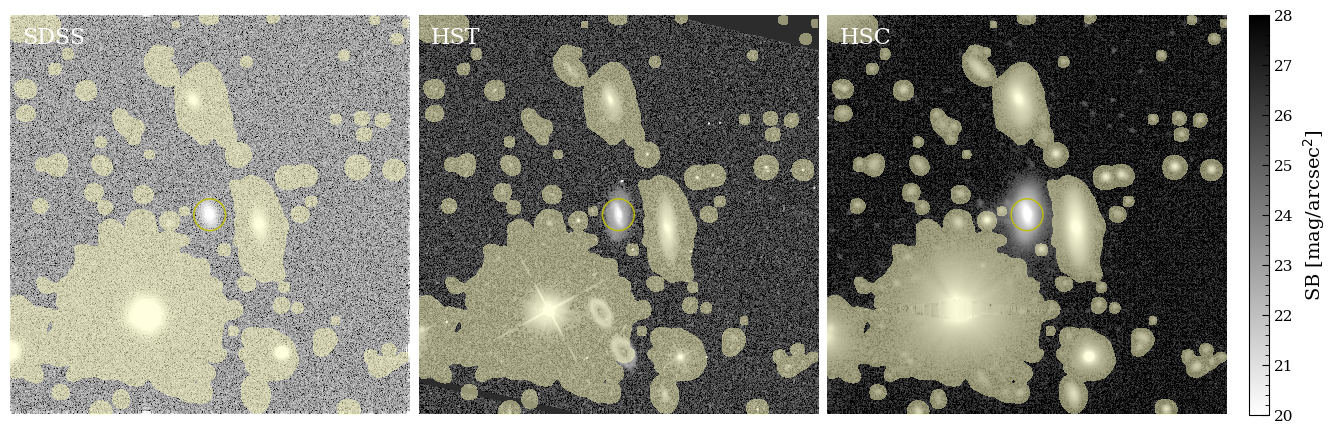

In [14]:
if example:
    
    ex_rpet, ex_cent = get_rpetro_circ(ex_hsc_f, ex_mask)
    
    fig, axs = make_cutout(*ex_files)
    for ax, mask, f in zip(axs, 3*[ex_mask], ex_files):
    
        # Find Petrosian radius
        ax.contourf(mask, cmap='Spectral', levels=[0.9, 1.1], alpha=0.5)
        ap = phot.aperture.CircularAperture(ex_cent, ex_rpet)
        ap.plot(ax=ax, color='y', lw=1)

We will use the HSC-based Rpet since we're using HSC-based segmentation maps for the first test.

## Asymmetry functions

In [15]:
def get_a_values(img, rpet, mask, raw_mask, psf, err):
    
    ap_size = 1.5*rpet
    
    # Non-fourier asymmetries
    a_sq = get_asymmetry(img, ap_size, mask, a_type='squared', sky_type='annulus', bg_corr='full', sky_annulus=[1.5, 3])
    a_cas = get_asymmetry(img, ap_size, mask, a_type='cas', sky_type='annulus', bg_corr='residual', sky_annulus=[1.5, 3])
    a_cas_corr = get_asymmetry(img, ap_size, mask, a_type='cas_corr', sky_type='annulus', bg_corr='residual', sky_annulus=[1.5,3])

    # Fourier asymmetry
#     # Estimate background noise
    # TODO: instead, interpolate and then add noise
    _, _, bgsd = sigma_clipped_stats(img, mask=mask)
    img_masked = img.copy()
    noise = np.random.normal(loc=0, scale=bgsd, size=img.shape)
    img_masked[mask] = noise[mask]
    err[mask] = bgsd
    img_deconv = fourier_deconvolve(img_masked, psf, err, convolve_nyquist=True)
    
    # Fourier asymmetry
    a_fourier = get_asymmetry(img_deconv, ap_size, mask, a_type='cas_corr', sky_type='annulus', bg_corr='residual', sky_annulus=[1.5,3])
    
    # Return all measurements
    res = {'a_cas' : a_cas[0], 'a_cas_corr' : a_cas_corr[0], 'a_sq' : np.sqrt(a_sq[0]), 'a_fourier' : np.sqrt(a_fourier[0]),
          'cent_cas' : a_cas[1], 'cent_cas_corr' : a_cas_corr[1], 'cent_sq' : a_sq[1]}
    return res, img_deconv

In [16]:
if example:
    res_arr = []
    fourier_imgs = []
    
    for ax, f, pxscale in zip(axs, ex_files, 3*[desired_pxscale]):
        # calculate asymmetries
        raw_mask = f['MASK'].data.astype(bool)
        mask = ex_mask.astype(bool) | raw_mask
        psf = f['PSF'].data
        err = f['ERR'].data
        res, img_fourier = get_a_values(f['IMAGE'].data.astype(float), ex_rpet, mask.astype(bool), raw_mask,  psf, err)
        res_arr.append(res)
        fourier_imgs.append(img_fourier)
        
    res_arr = pd.DataFrame(res_arr)
    
res_arr

a_cas  a_cas_corr      a_sq  a_fourier  \
0  0.092358    0.105965  0.559684   0.242469   
1  0.199002    0.203841  0.746300   0.394547   
2  0.127186    0.127186  0.471410   0.365173   

                                   cent_cas  \
0         [199.1845703125, 199.92431640625]   
1       [199.14794921875, 199.212646484375]   
2  [199.55129623413086, 199.60741996765137]   

                              cent_cas_corr  \
0         [199.1845703125, 199.92431640625]   
1  [199.21310424804688, 199.08103942871094]   
2  [199.55129623413086, 199.60741996765137]   

                                    cent_sq  
0    [198.7401580810547, 198.7655258178711]  
1   [199.18435096740723, 199.0186071395874]  
2  [199.60601806640625, 199.84970092773438]

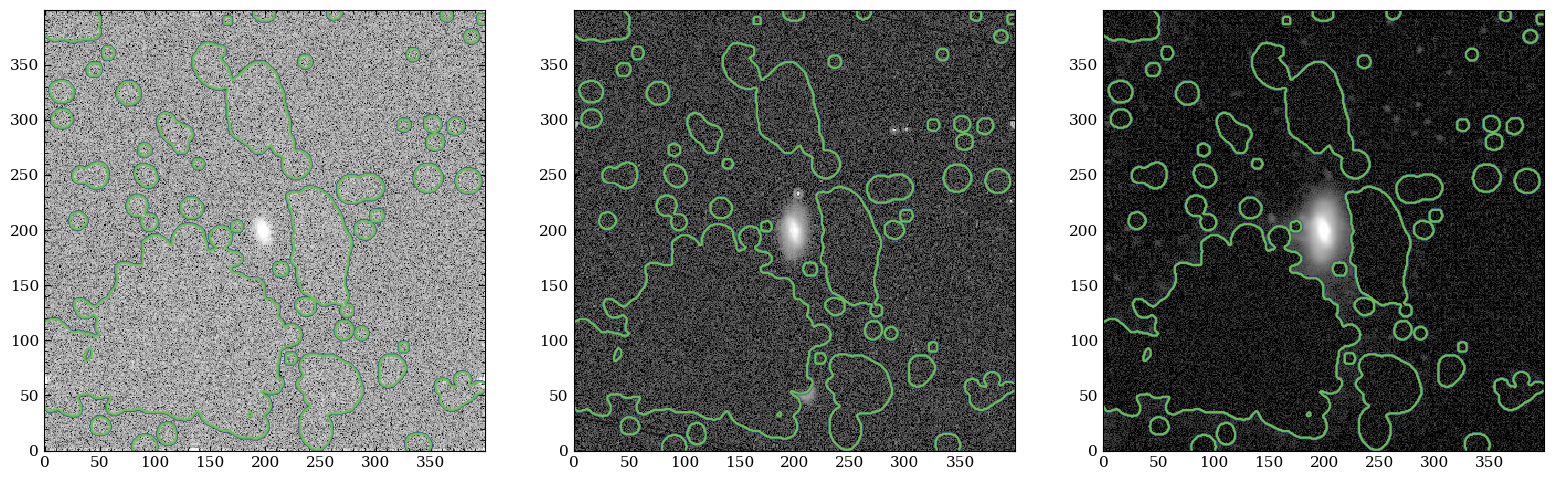

In [18]:
if example:
    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    zps = [2.5*9, ex_hst_f[0].header['zp'], 2.5*np.log10(ex_hsc_f[0].header['FLUXMAG0'])]

    for ax, img, zp in zip(axs, fourier_imgs, zps):

        im = -2.5*np.log10(np.abs(img/desired_pxscale**2)) + zp
        ax.imshow(im, vmin=20, vmax=28, cmap='gray_r')
        ax.contour(ex_mask, alpha=0.5)

## HSC-based segmaps

### Create segmaps

For each galaxy, create a segmap, and plot 

In [ ]:
res_df = []
fourier_images = []

sample = df

for idx, row in tqdm(sample.iterrows(), total=len(sample)):
    
    # Open files
    sdss_f = fits.open(f'data/sdss/i/{row["name"]}.fits')
    hst_f = fits.open(f'data/hst/F814W/{row["name"]}.fits')
    hsc_f = fits.open(f'data/hsc/{row["name"]}.fits')
    og_files = [sdss_f, hst_f, hsc_f]
    
    # Rescale everything
    files = []
    for i, f in enumerate(og_files):
        f_new = rescale(f, row.ra, row.dec, i==0)
        files.append(f_new)
        
    # Create segmap
    segmask = make_segmap(files[2])
    
    # Add object masks to masks
    masks = []
    for file in files:
        mask = segmask.astype(bool) | file['MASK'].data.astype(bool)
        masks.append(mask)
    
    # Calculate Rpet
    rpet, cent = get_rpetro_circ(files[2], masks[2])
    
    # Calculate asymmetry
    instruments = ['SDSS', 'HST', 'HSC']
    res_arrs = []
    imgs_deconv = []
    for i, (f, mask, instrument) in enumerate(zip(files, masks, instruments)):
        res, img_deconv = get_a_values(
            f['IMAGE'].data.astype(float), rpet, mask.astype(bool), 
            file['MASK'].data.astype(bool), f['PSF'].data, f['ERR'].data)
        res['name'] = row['name']
        res['instrument'] = instrument
        res_df.append(res)
        res_arrs.append(res)
        imgs_deconv.append(img_deconv)
    fourier_images.append(imgs_deconv)
        
    ############# Plot ############################
    # Make axes
    fig = plt.figure(figsize=(13,8))
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1)
    
    # Zeropoints for different images
    zps = [2.5*9, files[1]['IMAGE'].header['zp'], 2.5*np.log10(files[2]['IMAGE'].header['FLUXMAG0'])]
    
    # Define image size
    size = 40/desired_pxscale
    cent = 40/desired_pxscale
    
    labels = ['SDSS', 'HST', 'HSC']
    axs = []
    for i, (f, mask, label, zp, img_deconv, res) in enumerate(zip(files, masks, labels, zps, imgs_deconv, res_arrs)):
        # Convert to SB units
        img = -2.5*np.log10(np.abs(f['IMAGE'].data) / desired_pxscale**2) + zp
        img_deconv = -2.5*np.log10(np.abs(img_deconv) / desired_pxscale**2) + zp
        
        # Make axes
        ax = fig.add_subplot(2,3,(i+1))
        ax_deconv = fig.add_subplot(2,3,(i+4))
        
        # Plot the images
        im = ax.imshow(img, cmap='gray_r', vmin=20, vmax=28)
        ax_deconv.imshow(img_deconv, cmap='gray_r', vmin=20, vmax=28)
        
        # Overplot the masks
        ax.contourf(mask, cmap='Spectral', levels=[0.9, 1.1], alpha=0.5)
        
        # Overplot 1.5xRpet
        ap_rpet = phot.aperture.CircularAperture(res['cent_cas'], 1.5*rpet)
        ap_rpet.plot(ax=ax, color='w', lw=1)
        ap_rpet = phot.aperture.CircularAperture(res['cent_sq'], 1.5*rpet)
        ap_rpet.plot(ax=ax_deconv, color='w', lw=1)
        
        # Overplot the sky annulus
        skyap_rpet = phot.aperture.CircularAnnulus(res['cent_cas'], 1.5*1.5*rpet, 3.0*1.5*rpet, )
        skyap_rpet.plot(ax=ax, fc='C9', alpha=0.3, fill=True)
        skyap_rpet = phot.aperture.CircularAnnulus(res['cent_sq'], 1.5*1.5*rpet, 3.0*1.5*rpet)
        skyap_rpet.plot(ax=ax_deconv, fc='C9', alpha=0.3, fill=True)
        
        # Add a label for the instrument
        # color = 'w' 
        ax.annotate(label, xy=(0.03, 0.97), xycoords='axes fraction', color='w', size=16, va='top')
        
        # Add labels for asymmetry measurements
        ax.annotate(f'|A|={res["a_cas"]:0.2f}', xy=(0.97, 0.97), xycoords='axes fraction', color='w', size=16, va='top', ha='right')
        ax.annotate(fr'|A|$_c$={res["a_cas_corr"]:0.2f}', xy=(0.97, 0.89), xycoords='axes fraction', color='w', size=16, va='top', ha='right')
        ax.annotate(fr'A$^2$={res["a_sq"]:0.2f}', xy=(0.97, 0.81), xycoords='axes fraction', color='w', size=16, va='top', ha='right')
        ax_deconv.annotate(fr'F[A$^2$]={res["a_fourier"]:0.2f}', xy=(0.97, 0.97), xycoords='axes fraction', color='w', size=16, va='top', ha='right')
        
        axs.append([ax, ax_deconv])
        
    # Set axis limits
    axs = np.array(axs)
    for ax in axs.flatten():
        ax.axis('off')
        ax.set_xlim(cent-size, cent+size)
        ax.set_ylim(cent-size, cent+size)
        
    # Add a colorbar
    plt.subplots_adjust(wspace=0.01, hspace=0.01, left=0, bottom=0, top=1, right=0.94)
    cax = fig.add_axes([0.955, 0, 0.015, 1])
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label(r'SB [mag/arcsec$^2$]', size=14)
    
    plt.savefig(f'figures/asym_new/{row["name"]}.png', bbox_inches='tight')
    plt.close(fig)
        
    for f in files:
        f.close()
    

  0%|          | 0/30 [00:00<?, ?it/s]

/tmp/ipykernel_20945/2066843917.py:63: RuntimeWarning: divide by zero encountered in log10
  img = -2.5*np.log10(np.abs(f['IMAGE'].data) / desired_pxscale**2) + zp
/tmp/ipykernel_20945/3086394643.py:24: RuntimeWarning: invalid value encountered in sqrt
  res = {'a_cas' : a_cas[0], 'a_cas_corr' : a_cas_corr[0], 'a_sq' : np.sqrt(a_sq[0]), 'a_fourier' : np.sqrt(a_fourier[0]),
/tmp/ipykernel_20945/2066843917.py:63: RuntimeWarning: divide by zero encountered in log10
  img = -2.5*np.log10(np.abs(f['IMAGE'].data) / desired_pxscale**2) + zp
/home/liza/work/projects/morphology-tests/asymmetry.py:469: RuntimeWarning: invalid value encountered in divide
  fit_snr = fit_snr / ( psf_fft + 1/fit_snr )
/home/liza/work/projects/morphology-tests/asymmetry.py:513: RuntimeWarning: invalid value encountered in divide
  H = (nyquist_fft + 1/snr) / (psf_fft + 1/snr)
/home/liza/miniconda3/envs/astro/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_

In [25]:
res_df = pd.DataFrame(res_df)

In [26]:
# with open('data/fourier_images_better.pkl', 'wb') as f:
#     pickle.dump(fourier_images, f)
    
# with open('data/res_df_better.pkl', 'wb') as f:
#     pickle.dump(res_df, f)

In [27]:
sdss = res_df[res_df.instrument == 'SDSS']
hsc =  res_df[res_df.instrument == 'HSC']
hst =  res_df[res_df.instrument == 'HST']

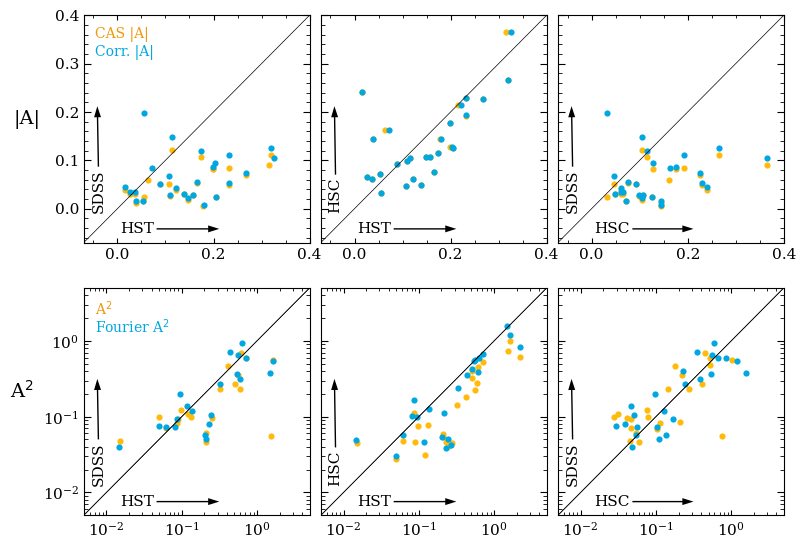

In [124]:
fig, axs = plt.subplots(2,3, figsize=(7,5), sharey='row')

dfs1 = [hst, hst, hsc]
dfs2 = [sdss, hsc, sdss]

s = 80
for i in range(3):
    axs[0,i].scatter(dfs1[i].a_cas, dfs2[i].a_cas, s=s, color='#FFBA0A')
    axs[0,i].scatter(dfs1[i].a_cas_corr, dfs2[i].a_cas_corr, s=s, color='#00A7E1')
    axs[1,i].scatter(dfs1[i].a_sq, dfs2[i].a_sq, s=s, color='#FFBA0A')
    axs[1,i].scatter(dfs1[i].a_fourier, dfs2[i].a_fourier, s=s, color='#00A7E1')
    
for ax in axs.flatten():
    ax.plot([0,1],[0,1], color='k', lw=0.5, transform=ax.transAxes)
    
for ax in axs[0]:
    ax.set_xlim(-0.07, 0.4)
    ax.set_ylim(-0.07, 0.4)
    
for ax in axs[1]:
    ax.plot([0, 5], [0, 5], color='k', lw=0.5)
    ax.set_xlim(0.005, 5)
    ax.set_ylim(0.005, 5)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
ylabels = ['SDSS', 'HSC', 'SDSS']
xlabels = ['HST', 'HST', 'HSC']

for i in range(3):
    for ax in axs[:,i]:
        ax.annotate(ylabels[i], xy=(0.06, 0.6), xytext=(0.065, 0.13), xycoords='axes fraction', textcoords='axes fraction',
                    rotation=90, ha='center', va='bottom', arrowprops=dict(facecolor='black', width=1, headwidth=5, headlength=8))
        ax.annotate(xlabels[i], xy=(0.6, 0.06), xytext=(0.16, 0.06), xycoords='axes fraction', textcoords='axes fraction',
                    ha='left', va='center',  arrowprops=dict(facecolor='black', width=1, headwidth=5, headlength=8))
    
axs[0,0].annotate('CAS |A|', color='#EE990A', xy=(0.05, 0.95), xycoords='axes fraction', va='top', ha='left', size=10, weight=500)
axs[0,0].annotate('Corr. |A|', color='#00A7E1', xy=(0.05, 0.87), xycoords='axes fraction', va='top', ha='left', size=10, weight=500)

    
axs[1,0].annotate(r'A$^2$', color='#EE990A', xy=(0.05, 0.95), xycoords='axes fraction', va='top', ha='left', size=10, weight=500)
axs[1,0].annotate(r'Fourier A$^2$', color='#00A7E1', xy=(0.05, 0.87), xycoords='axes fraction', va='top', ha='left', size=10, weight=500)

labels = ['|A|']
axs[0,0].set_ylabel('|A|', rotation=0, labelpad=20, size=14)
axs[1,0].set_ylabel(r'A$^2$', rotation=0, labelpad=15, size=14)
    

plt.subplots_adjust(wspace=0.05)
plt.savefig('figures/result.png', bbox_inches='tight')

In [3]:
from scipy.integrate import quad

In [31]:
def normal(x, A, mu, std):
    return A * np.exp(-(x-mu)**2 / (2*std**2)) / (np.sqrt(2*np.pi)*std)

def fun(x):
    
    y1 = normal(x, 1, -3, 0.6)
    y2 = normal(x, 0.7, 1, 0.5)
    y3 = normal(x, 0.1, 0, 0.1)
    y4 = normal(x, 0.5, -2, 1)
    
    # y = np.sin(x)
    return y1+y2#+y3+y4

xs = np.linspace(-10, 10, 500)
ys = fun(xs)

# plt.plot(xs, ys, color='k', label='I(x)')
# plt.xlabel('x')

x0s = np.linspace(-3, 3, 150)
asyms = []
for x0 in x0s:
    
    asym = quad(lambda x: np.abs(fun(x) - fun(2*x0-x)), -np.inf, np.inf)
    asyms.append(asym[0])
    
    # ys_rot = fun(2*x0 - xs)

# x0s = [-1]#, 1]
# colors = ['C1', 'C1']
# for x0, color in zip(x0s, colors):
#     ys_rot = fun(2*x0 - xs)
#     yplot = np.abs(ys-ys_rot)
#     plt.plot(xs, yplot, color=color, lw=1, ls='--', label='|Difference|')
#     plt.plot(xs, ys_rot, color=color, lw=1, label=f'Reflect about {x0}')
#     plt.legend(frameon=False)

/tmp/ipykernel_957/227597449.py:24: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  asym = quad(lambda x: np.abs(fun(x) - fun(2*x0-x)), -np.inf, np.inf)


In [32]:
# ys = ex_hst_f[0].data
# ys = T.rescale(ys, 0.1)
# ys = ys[101]
# psf = Gaussian1DKernel(30, x_size=len(ys))
# psf_fft = (fft(psf))

# # # [1010]
# xs = np.arange(len(ys))

Text(1.4, 3, 'Best x0')

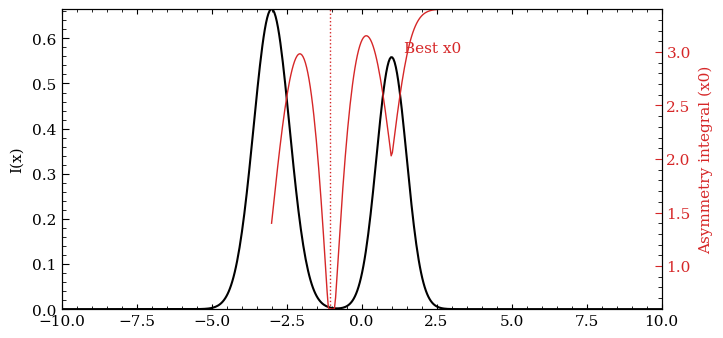

In [33]:
# plt.plot(xs, ys, color='k', label='I(x)')
# plt.xlabel('x')

fig = plt.figure(figsize=(6,3))
ax = plt.axes()
ax.plot(xs, ys, color='k')
ax.set_ylabel('I(x)')
ax2 = ax.twinx()
ax2.plot(x0s, asyms, color='C3', lw=1)
ax2.tick_params(color='C3', labelcolor='C3')
ax2.set_ylabel('Asymmetry integral (x0)', color='C3')


ax2.axvline(x0s[np.argmin(asyms)], color='C3', lw=1, ls=':')
ax2.annotate('Best x0', xy=(1.4, 3), xycoords='data', color='C3')

In [34]:
from scipy.fftpack import fft, rfft, fftfreq, ifft, fftshift
from scipy.optimize import minimize_scalar
from astropy.convolution import Gaussian1DKernel

(-1e-08, 1e-08)

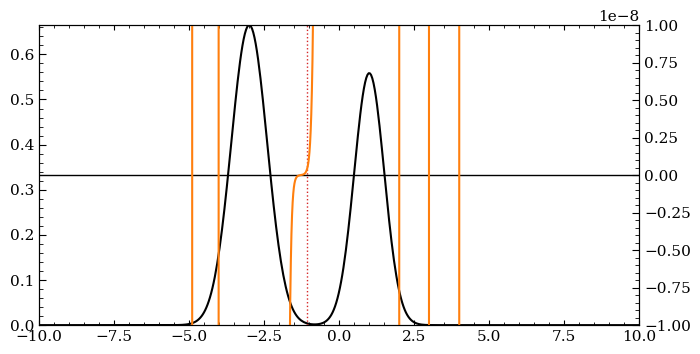

In [36]:
fig = plt.figure(figsize=(6,3))
yfft = fft(ys)
dx = np.diff(xs)[0]
freq = np.fft.fftfreq(len(ys), d=dx)
deriv = yfft*yfft * freq * 1j * 2*np.pi

res = ifft(deriv) 

ax = plt.axes()
plt.plot(xs, ys, color='k')
plt.axvline(x0s[np.argmin(asyms)], color='C3', lw=1, ls=':')

ax2 = plt.twinx()
ax2.axhline(0, color='k', lw=1)
ax2.plot(xs/2, res, color='C1')
ax2.set_ylim(-0.00000001, 0.00000001)
# ax2.set_yscale('log')

# plt.yscale('log')